In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import numpy as np
import random
from matplotlib import pyplot as plt
import scipy.ndimage as nd
from tqdm.notebook import trange

%matplotlib inline

<div class="alert alert-success">
    <h1>Implementació de l'algorisme Seam Carving</h1>
</div>

Funcions auxiliars:

In [5]:
def get_gradient(im):
    """
    Donada una imatge, en calcula el gradient

    Params
    ======
    :im: Imatge de la que en volem calcular el gradient

    Returns
    =======
    :gradient: Gradient horitzontal de la imatge

    """

    # Transformem la imatge a un sol canal (blanc i negre)
    im_blackwhite = np.dot(im[...,:3], [0.299, 0.587, 0.114])

    # Calculem el gradient usant sobel
    gradient = np.abs(nd.sobel(im_blackwhite))
    return gradient #aixo és una matriu


def show_row(im_and_titles):
    """
    Donat un conjunt d'imatges i els seus títols, els mostra en una sola línia

    Params
    ======
    :im_and_titles: Llista de tuples en el format [(im, title), ...]
    """

    # Creem una figura d'una sola línia
    fig, axs = plt.subplots(1,len(im_and_titles),figsize=(len(im_and_titles)*8,5))

    # Iterem el conjunt d'imatges i mostrem la imatge amb el seu títol
    for i, (im, title) in enumerate(im_and_titles):
        axs[i].imshow(im)
        axs[i].set_title(title)
        axs[i].set_axis_off()

    plt.tight_layout()
    plt.show()


def add_min_path(im, path, color=[1,0,0]):
    """
    Donada una imatge i un camí, afegeix el camí en un color donat. Per defecte, vermell.

    Params
    ======
    :im: Imatge sense el camí
    :path: Camí que volem afegir
    :color: Color del camí

    Returns
    =======
    :im: Imatge amb el camí afegit
    """
    for i, j in path:
        im[i][j]=color
    return im

Exemple d'ús:

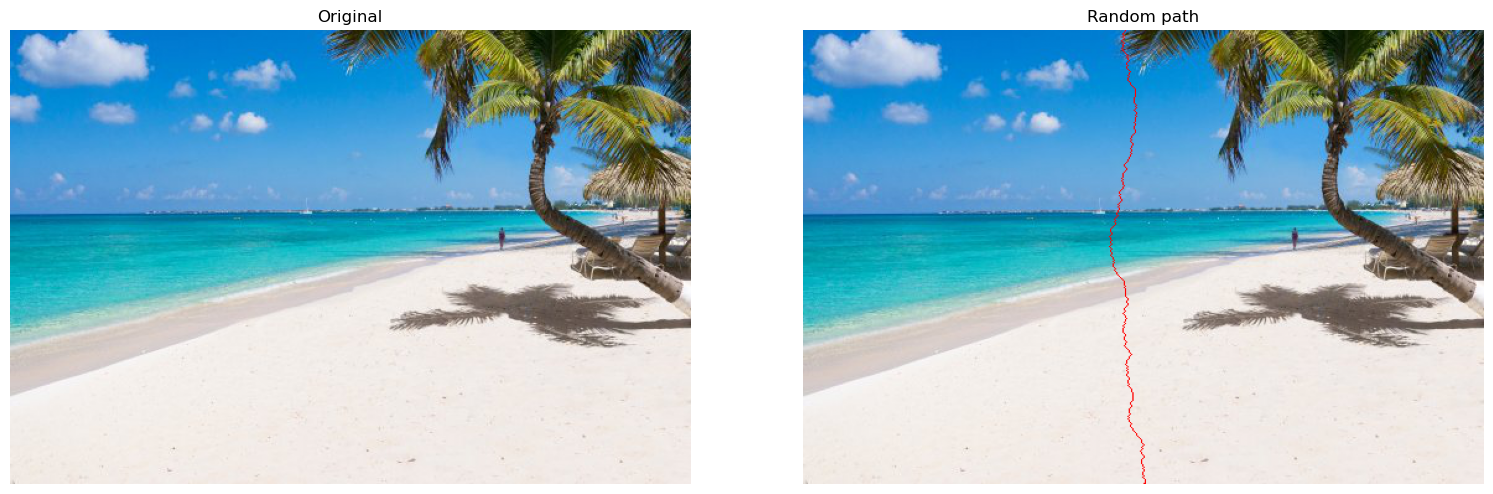

In [6]:
# Carreguem una imatge
im = plt.imread('img/beach.jpg')/255

# Creem un camí aleatori
i = im.shape[0]-1
path = [(i, im.shape[1]//2)]
while i >= 0:
    path.append((i, min(max(0, path[-1][1] + random.randint(-1,1)),im.shape[1]-1)))
    i-=1

# Afegim el camí a una imatge diferent
im_path = im.copy()
im_path = add_min_path(im_path, path)

# Usem la funció show_row per mostrar les imatges amb els seus títols.
im_titles = [(im, 'Original'), (im_path, 'Random path')]
show_row(im_titles)

In [7]:
def superior_neighbors(mat, point):
    """
    Donada una matriu de mida H x W i punt, retorna els punts de la fila superior adjacents al punt passat com a paràmetre.
    Cal tenir en compte els següents casos. Considerant que el punt té coordenades (i,j):
        - Si el punt té coordenada j=0, vol dir que estem agafant un punt del marge esquerre de la imatge. Només s'han de retornar DOS veïns.
        - Si el punt té coordenada j=(W-1), vol dir que estem agafant un punt del marge dret de la imatge. Només s'han de retornar DOS veïns.
        - En la resta de casos, es retornen els tres veïns superiors.

    Params
    ======
    :mat: Una matriu 2-Dimensional
    :point: Un sol punt amb el format (i,j)

    Returns
    =======
    :neighbors: Una llista de dos o tres elements en funció de cada cas.
    """

    neighbors=[]
    i, j = point

    #if i != 0:
      #Per cada possible combinació, extreiem els punts i els posem
    if j == 0:
        neighbors.append((i-1, j))
        neighbors.append((i-1, j+1))
    elif j == len(mat[0]) - 1:
        neighbors.append((i-1, j-1))
        neighbors.append((i-1, j))
    else:
        neighbors.append((i-1, j-1))
        neighbors.append((i-1, j))
        neighbors.append((i-1, j+1))

    return neighbors #AQUI HAURIEM DE FER np.array(neighbors), ja que així sens donava
                     #El programa funcionaria exactament igual, però triga bastant més, així que ho hem deixat així
                        #(Triga el doble...)

def minimal_paths(mat):
    """
    Creació de tots els camins mínims usant programació dinàmica.
    Cal usar la funció 'superior_neighbors' per trobar els veïns.

    Params
    ======
    :mat: Matriu 2-Dimensional d'entrada (gradient)

    Returns
    =======
    :ret: Matriu 2-Dimensional de la mateixa mida que 'mat' amb els camins mínims calculats.
    """
    ret = mat.copy()

    #Aixo és una matriu. n*n. Actualitzem el cost de cada pixel (anem per files), mirant els costos de dalt

    #Per cada fila (menys la primera fila)
    for i in range(1,len(mat)):
        #Per cada columna
        for j in range(len(mat[0])):
            sup=superior_neighbors(mat,(i,j)) #Escollim dels possibles veins el camí més baix
            min_res=float('inf')
            #Calculem el camí mínim, a segons de la formula donada!
            for (p1,p2) in (sup):
                min_res= min(min_res,mat[i][j] + ret[p1][p2])
            ret[i][j]=min_res

    return ret


def find_min_path(mat):
    """
    Donada una matriu, calcula el camí mínim sobre aquesta. L'algorisme ha de començar per la part inferior i buscar el següents punts.

    Params
    ======
    :mat: Matriu de camins mínims

    Returns
    =======
    :min_path: Una llista de tuples amb les coordenades (i,j) del camí mínim. La primera coordenada ha d'anar decrementant sempre en 1.
               Exemple. Suposant que una imatge té d'alçada 341 píxels, un possible camí seria: [(340, 120), (339, 121), (338,120), ..., (0, 151)]
    """

    min_path = [] #Aqui hi han les posicions en tuples (i,j)

    # Primer buscarem el primer punt on sortirem
    punt=(len(mat)-1,0)
    min_camin_cost=mat[len(mat)-1][0]

    for i in range(len(mat[0])):
        if mat[len(mat)-1][i]< min_camin_cost: #Hem danar veient quin punt té el gradient més petit
            min_camin_cost=mat[len(mat)-1][i]
            punt=(len(mat)-1,i)

    min_path.append(punt) #Ara, tenim el punt amb el gradient més petit a la primera fila

    #Ara ens construirem el minimal_path
    for i in range(len(mat)-1,0,-1):
        sup=superior_neighbors(mat,punt) #possibles camins
        min_possible_opcio=float('inf')
        for (p1,p2) in sup:
            if(mat[p1][p2]<min_possible_opcio): #busquem la opcio més petita de totes les que podem fer!
                min_possible_opcio= mat[p1][p2]
                punt=(p1,p2)
        min_path.append(punt)

    return min_path


def delete_path(im, path):
    """
    Donat una imatge i un camí, elimina els pixels de la imatge que pertanyen del camí.
    Podeu usar la següent instrucció per inicialitzar la imatge. Això crea una imatge amb tots els valors a zero.

    im_new = np.zeros((im.shape[0], im.shape[1]-1, im.shape[2]))

    Params
    ======
    :im: Una imatge de mida H x W x 3
    :path: Un camí sobre la imatge.

    Returns
    =======
    :im_new: Una nova imatge de mida H x (W-1) x 3 amb el camí eliminat
    """
    #la nova imatge
    im_new = np.zeros((im.shape[0], im.shape[1]-1, im.shape[2]))

    # La idea és eliminar el camí, i copiar tota la matriu (la resta)
    for i in range(im.shape[0]):
            for j in range(path[len(path)-1-i][1]): #ens parem fins a on el path actua!!; ojo que el path està al revés de com estem iterant!
                im_new[i][j]=im[i][j]
            for j in range(path[len(path)-1-i][1],im.shape[1]-1): #A partir d'alla, tornem a copiar novament
                im_new[i][j]=im[i][j+1] #Hem de copiar una columna de dreta de més!

    return im_new

def reduce_image(im, N=100):
    """
    Implementació de l'algorisme Seam Carving.
    Useu la funció 'show_row' al finalitzar per mostrar una figura amb tres subfigures:
        - Imatge original
        - Primer camí que s'elimina
        - Imatge resultant després de N iteracions

    Params
    ======
    :im: Imatge que volem reduir
    :N: Nombre de cops que repetirem l'algorisme
    """

    im_final = im.copy()
    for i in range(N):
      #print(i) #aeixem aquests prints així es veu la velocitat
      gradient = get_gradient(im_final) #aconseguim el gradient
      minims_camins = minimal_paths(gradient) #aconseguim els minimal_paths
      minim_cami = find_min_path(minims_camins) #aconseguim el min_path
      im_final = delete_path(im_final, minim_cami) #creem la nova imatge

      if i == 0: #Aixó és per fer el show_row
        im_primerCami = im_final.copy()
        im_primerCami = add_min_path(im_primerCami, minim_cami)

        # Usem la funció show_row per mostrar les imatges amb els seus títols.
    im_titles = [(im, 'Original'), (im_primerCami, 'Eliminacio del 1r camí'), (im_final, 'Imatge resultant')]

    show_row(im_titles)


Comproveu la vostra solució

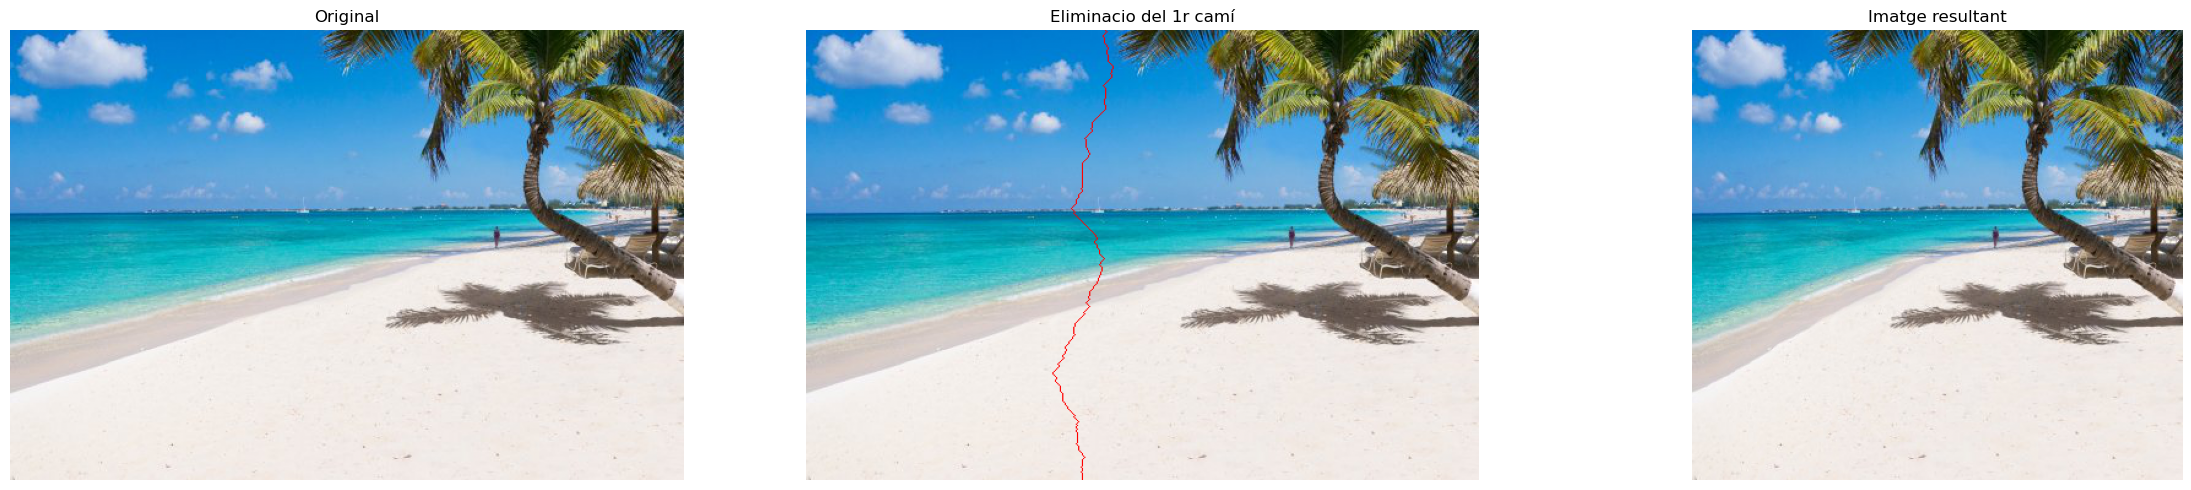

In [8]:
im = plt.imread('img/beach.jpg')/255
reduce_image(im, 150)

<div class="alert alert-success">
    <h1>Problema 2: Eliminar objectes d'una imatge</h1>
</div>

In [11]:
def add_patch(im, patch):
    """
    Donada una imatge i un patch. Mostra la imatge amb el patch d'un color donat. Per defecte, vermell.

    Params
    ======
    :im: La imatge a la que volem afegit el patch
    :patch: Patch amb quatre coordenades. Format: [(i1,j1), (i2, j2)]

    Returns
    =======
    :im: Imatge amb els píxels del patch en vermell.
    """

    for i in range(patch[0][0], patch[1][0]+1):
        for j in range(patch[0][1], patch[1][1]+1):
            im[i][j] = [1,0,0]
    return im

def canviar_gradient(grad,patch):
    """
    Donat un gradient, posa a un valor molt petit els pixels a dins del patch

    Params
    ======
    :grad: Gradient original
    :patch: Patch amb dos parells de coordenades.

    Returns
    =======
    :grad: Gradient modificat amb els valors del patch en -inf
    """

    for i in range(patch[0][0], patch[1][0]+1):
        for j in range(patch[0][1], patch[1][1]+1):
            grad[i][j] = -1 #triem -1 pels valors del gradient

    return grad

def upgrade_patch(patch):

    #Hem de reduir el patch de una columna. Fixem-nos que com que el path es carrega una columna (o un cami que va
        #de dalt fins a baix), aleshores amb que reduim el patch una columna ya està!
        #El patch té els mateixos valors (és tot vermell), per tant mentre ens carreguem una columna (la de la dreta) ya està!

    p1=patch[1][1]-1
    p2=patch[1][0]
    patch[1]=(p2,p1)
    return patch

def remove_patch(im, patch):
    """
    Donada una imatge i un patch, n'elimina tots els punts interiors al patch.
    Useu la funció 'show_row' al finalitzar per mostrar una figura amb tres subfigures:
        - Imatge original
        - Imatge amb el patch de color vermell
        - Imatge resultant després d'eliminar el patch

    Params
    ======
    :im: Imatge original
    :patch: Patch amb dos parells de coordenades.
            Format: [(i1,j1), (i2, j2)]. Sempre se satisfà que i1<i2, j1<j2.
            (i1, j1) és la coordenada superior esquerra del patch
            (i2, j2) és la coordenada inferior dreta del patch.
            Aquestes dues parelles s'han d'incloure com a part del patch.
    """
    #Hem de canviar el gradient a -inf a on toqui de la imatge

    # Copiem la imatge per no modificar-la
    im_principi = np.copy(im)
    # Fem el patch vermell
    im_vermella = np.copy(im)
    add_patch(im_vermella, patch)

    #Posem els indexs
    n = patch[0][1]
    m = patch[1][1]+1
    for i in range(n,m):
        #print(i) #deixem aquests prints així es veu la velocitat
        g=get_gradient(im) #extraiem el gradient

        g=canviar_gradient(g,patch) #modifiquem el gradient

        min_p=minimal_paths(g) #trobem els camins minims en el gradient
        path=find_min_path(min_p) #trobem el cami minim

        patch=upgrade_patch(patch) #upgrade_patch
        im=delete_path(im,path)

    # Usem la funció show_row per mostrar les imatges amb els seus títols.
    im_titles = [(im_principi, 'Original'), (im_vermella, 'Patch vermell'), (im, 'Imatge resultant')]
    show_row(im_titles)

Comproveu la vostra solució.

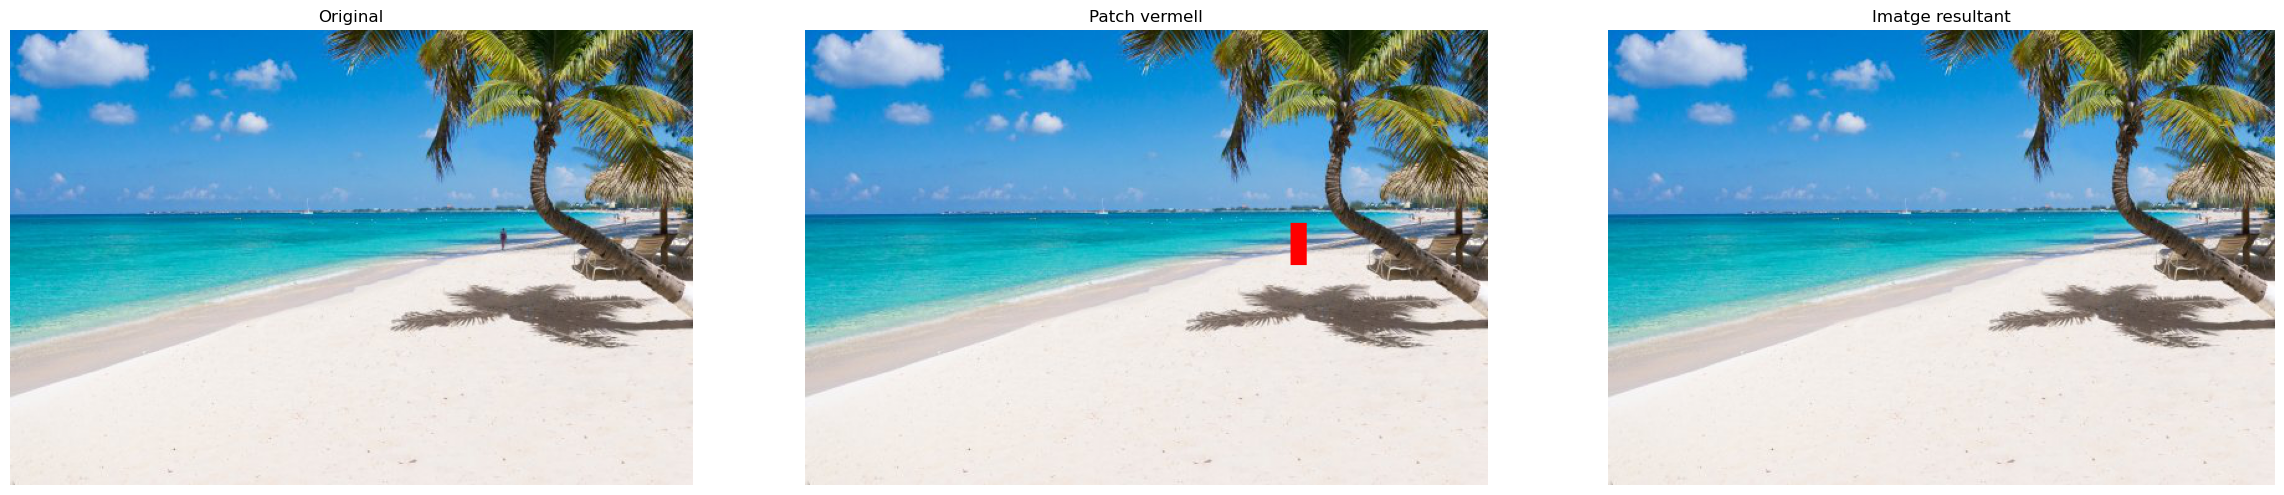

In [12]:
im = plt.imread('img/beach.jpg')/255
patch = [(156,391), (189,403)]

remove_patch(im, patch)